In [1]:
from langchain_community.vectorstores import FAISS
import os 
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI,OpenAIEmbeddings 
from langgraph.graph import START, END,StateGraph
from langchain.schema import Document
from typing import TypedDict,List

d:\langchain2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from dotenv import load_dotenv
from langchain_community.embeddings import HuggingFaceEmbeddings

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm=ChatOpenAI(model="gpt-4.1", temperature=0)
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14424\1449736368.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")


state function

In [3]:
class AgentState(TypedDict):
    question: str
    documents:List[Document]
    answer: str
    need_retrival= bool

retriver

In [5]:
sample_texts = [
    "Effective financial management helps organizations allocate resources efficiently and achieve long-term goals.",
    "Budgeting is a crucial part of financial management that ensures spending aligns with income.",
    "Cash flow management helps businesses maintain liquidity and avoid short-term financial crises.",
    "Good financial decisions are based on analyzing risks, returns, and market trends.",
    "Personal financial management involves saving, investing, and controlling expenses wisely.",
]

agent state

In [6]:
documents=[Document(page_content=text) for text in sample_texts]

#create vector store
vectorstore = FAISS.from_documents(documents, embeddings)
retriever=vectorstore.as_retriever(k=3)

In [31]:
def decide_retrival(state: AgentState) -> AgentState:
    """decide when to retrieve documents based on question"""

    question= state['question']
    retrival_keyword=["what","how","explain","describe","tell me"]
    needs_retrieval= any(keyword in question.lower() for keyword in retrival_keyword)

    return {**state, "needs_retrieval":needs_retrieval}


In [32]:
def retrieve_documents(state : AgentState) -> AgentState:
    """retrieve relevant document based on question"""

    question= state["question"]
    documents= retriever.invoke(question)

    return {**state,"document":documents}

In [ ]:
def generate_answer(state: AgentState)-> AgentState:
    """ retrieve the answer based on documents or direct answer"""
    question=state["question"]
    documents= retriever.get("documents",[])

    if documents:
        context= "\n\n".join([doc.page_content for doc in documents])
        prompt = f"""based on the following context answer the question
        Context:{context}

        Question: {question}

    Answer:"""
    else :
        prompt = f"answer the following question: {question}"

    response = llm.invoke(prompt)
    answer= response.content

    return {**state, "answer": answer }



conditional logic


In [34]:
def should_retrieve(state:AgentState)-> str:
    """ determine the next step based on retrival decision """

    if state ["needs_retrieval"]:
        return "retrieve"
    else :
        return "generate"
    

build the graph 

In [35]:
workflow= StateGraph(AgentState)

workflow.add_node("decide", decide_retrival)
workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)

workflow.set_entry_point("decide")

workflow.add_conditional_edges(
    "decide",
    should_retrieve,
    {
        "retrieve" : "retrieve",
        "generate" : "generate"
    }
)

workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END )

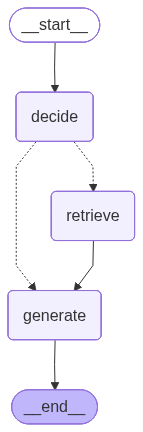

In [36]:
app = workflow.compile()
app

test agent system

In [37]:
def ask_question( question: str):
    """
    help function to ask a question and get an answer
    """

    initial_state= {
        "question" : question,
        "documents" :[],
        "answer": "",
        "needs_retrieval": False
    }

    result= app.invoke(initial_state)
    return result

In [38]:
question1 = "tell me about financial management"
result1= ask_question(question1)
result1

KeyError: 'needs_retrieval'